In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Utils file for pre processing text and prepare dataset

In [ ]:
import os, re
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')

def normalize_text(text):
    # convert to lower case
    text = text.lower()

    # replace contractions with full words
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)
    stops = set(stopwords.words('english'))

    filtered_tokens = [
        token for token in tokens
        if token not in stops and token.isalpha()
    ]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # 8. Join tokens back into a single string
    return ' '.join(lemmatized_tokens)


def read_txt_file(file_path):
    with open(file_path, "r") as f:
        return f.readlines()


def create_vocab(lines, min_freq):
    total_word_counts = []
    word2index = {"<PAD>": 0, "<UNK>": 1, "<SOS>": 2, "<EOS>": 3}
    word2count = {}
    for sample in lines:
        text = sample.split("\t")[0]
        word_count = len(text.split())
        total_word_counts.append(word_count)
        for w in text.split():
            if w not in word2count:
                word2count[w] = 1
            else:
                word2count[w] += 1

    for w, c in word2count.items():
        if c >= min_freq:
            word2index[w] = len(word2index)
    return word2index, total_word_counts


def convert_to_sentiment(label):
    if (int(label) <= 2):
        return 'negative'
    elif (int(label) == 3):
        return 'neutral'
    else:
        return 'positive'

def prepare_dataset(csv_file):
    print("Preparing dataset...")

    # Load CSV file
    df = pd.read_csv(csv_file)
    df.columns = ['label', 'text']
    df['label'] = df['label'].apply(convert_to_sentiment)
    sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['label'] = df['label'].map(sentiment_mapping)
    dataset = []

    # Process each row in the CSV file
    for _, row in df.iterrows():
        text = normalize_text(str(row["text"]))
        label = str(row["label"])
        sample = f"{text}\t{label}"
        dataset.append(sample)

    np.random.shuffle(dataset)
    word2index, total_word_counts = create_vocab(dataset, 25)
    print(f"Vocab size:", len(word2index))

    # create train/val/test
    n_train = int(len(dataset) * 0.8)
    n_val = int(len(dataset) * 0.1)
    dataset = {
        "train": dataset[:n_train],
        "val": dataset[n_train : n_train + n_val],
        "test": dataset[-n_val:],
    }
    return dataset, word2index, total_word_counts

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Model Defination

In [8]:
import torch

class LSTMClassifier(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout, n_layers, n_classes):
        super(LSTMClassifier, self).__init__()
        self.embedding_layer = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn = torch.nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=0.3, batch_first=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.out = torch.nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        embedded = self.embedding_layer(x["input_ids"])
        pcked = torch.nn.utils.rnn.pack_padded_sequence(
            embedded,
            x["length"],
            enforce_sorted=False,
            batch_first=True,
        )

        output, _ = self.rnn(pcked)
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(
            output,
            padding_value=2,
            batch_first=True,
        )
        output = output[range(len(output)), x["length"] - 1]
        output = self.dropout(output)
        return self.out(output)


### Data defination

In [9]:
class YelpReviews(torch.utils.data.Dataset):
    def __init__(self, data, word2index, max_sent_length, device):
        self.data = data
        self.word2index = word2index
        self.max_sent_length = max_sent_length
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        text, label = sample.split("\t")
        label = int(label)
        input_ids, _text, text_length = self.text2indices(text)
        return {
            "text": _text,
            "input_ids": torch.tensor(input_ids).to(self.device),
            "label": torch.tensor(label).to(self.device),
            "length": text_length,
        }

    def text2indices(self, sentence):
        sos_id = self.word2index["<SOS>"]
        eos_id = self.word2index["<EOS>"]
        pad_id = self.word2index["<PAD>"]
        unk_id = self.word2index["<UNK>"]
        input_ids, text = [sos_id], ["<SOS>"]
        for w in sentence.split():
            token_id = self.word2index.get(w, unk_id)
            input_ids.append(token_id)
            if token_id == unk_id:
                text.append("<UNK>")
            else:
                text.append(w)

        if len(input_ids) >= self.max_sent_length:  # truncate
            text = text[: self.max_sent_length]
            text.append("<EOS>")
            input_ids = input_ids[: self.max_sent_length]
            input_ids.append(eos_id)
            text_len = len(input_ids)

        else:  # pad
            to_add = self.max_sent_length - len(input_ids)
            text.append("<EOS>")
            input_ids.append(eos_id)
            text_len = len(input_ids)
            text.extend(["<PAD>"] * to_add)
            input_ids.extend([pad_id] * to_add)

        return input_ids, " ".join(text), text_len


def make_dataloader(dataset, word2index, max_sent_length, batch_size, device):
    ds = YelpReviews(dataset, word2index, max_sent_length, device)
    return torch.utils.data.DataLoader(ds, batch_size, shuffle=True)

### Training and validation loop

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random
from itertools import product

# Get path to dataset.csv
data_dir = "/content/drive/MyDrive/datasets/test.csv"

def train(dloader, model, criterion, optimizer):
    model.train()
    train_losses, train_accs = [], []
    for batch in tqdm(dloader, desc="Training"):
        y = batch["label"]
        logits = model(batch)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        preds = torch.argmax(logits, -1)
        train_accs.append((preds == y).float().mean().item())

    avg_loss = np.array(train_losses).mean()
    avg_acc = np.array(train_accs).mean()

    print(
        f"Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_acc:.4f}"
    )

    return avg_loss, avg_acc

@torch.no_grad()
def test(dloader, model, criterion):
    model.eval()
    test_losses, test_accs = [], []
    for batch in tqdm(dloader, desc="Evaluating"):
        y = batch["label"]
        logits = model(batch)
        loss = criterion(logits, y)
        test_losses.append(loss.item())
        preds = torch.argmax(logits, -1)
        test_accs.append((preds == y).float().mean().item())

    avg_loss = np.array(test_losses).mean()
    avg_acc = np.array(test_accs).mean()

    print(f"Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f}")

    return avg_loss, avg_acc

def save_cp(model):
    if not os.path.exists("checkpoints"):
        os.makedirs("checkpoints")
    torch.save(model.state_dict(), "checkpoints/lstm_model.pt")

# Reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
dataset, word2index, total_word_counts = prepare_dataset(data_dir)

In [ ]:
# do hyperparameter tunning here
param_grid = {
    'embedding_dim': [128, 256],
    'hidden_dim': [64, 128],
    'dropout': [0.3, 0.5],
}

# Randomly sample combinations
combinations = list(product(*param_grid.values()))
random.shuffle(combinations)
combinations = combinations
EPOCHS = 5

best_val_acc = 0
best_pair = {}

for i, combo in enumerate(combinations):
    print(f"\n🔁 Trial {i+1}: Params = {combo}")
    embedding_dim, hidden_dim, dropout = combo
    model = LSTMClassifier(len(word2index), embedding_dim, hidden_dim, dropout, 2, 3)
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=1e-3)

    train_dloader = make_dataloader(dataset["train"], word2index, 256, 16, device)
    val_dloader = make_dataloader(dataset["val"], word2index, 256, 16, device)

    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
      print(f"===Epoch {epoch}===")
      print("Training...")
      train_loss, train_acc = train(train_dloader, model, criterion, optimizer)
      print("Validating...")
      val_loss, val_acc = test(val_dloader, model, criterion)

      train_accs.append(train_acc)
      val_accs.append(val_acc)

    val_acc = np.mean(val_accs)
    if(val_acc > best_val_acc):
        best_val_acc = val_acc
        best_pair = combo
        print(f"best pair currently is {combo}")



🔁 Trial 1: Params = (128, 128, 0.5)
===Epoch 0===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 46.65it/s]


Train Loss: 1.0620 | Train Accuracy: 0.4211
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 138.10it/s]


Loss: 1.0489 | Accuracy: 0.4627
===Epoch 1===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 49.26it/s]


Train Loss: 1.0471 | Train Accuracy: 0.4675
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 132.52it/s]


Loss: 1.0307 | Accuracy: 0.4978
===Epoch 2===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 50.13it/s]


Train Loss: 0.9728 | Train Accuracy: 0.5457
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 134.91it/s]


Loss: 0.9348 | Accuracy: 0.5759
===Epoch 3===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.43it/s]


Train Loss: 0.8998 | Train Accuracy: 0.6040
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 137.01it/s]


Loss: 0.8920 | Accuracy: 0.6072
===Epoch 4===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.87it/s]


Train Loss: 0.8600 | Train Accuracy: 0.6296
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 136.13it/s]


Loss: 0.8662 | Accuracy: 0.6254
best pair currently is (128, 128, 0.5)

🔁 Trial 2: Params = (256, 64, 0.5)
===Epoch 0===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 50.17it/s]


Train Loss: 1.0660 | Train Accuracy: 0.3988
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 122.45it/s]


Loss: 1.0523 | Accuracy: 0.4261
===Epoch 1===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.99it/s]


Train Loss: 1.0540 | Train Accuracy: 0.4305
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 128.44it/s]


Loss: 1.0457 | Accuracy: 0.4748
===Epoch 2===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.82it/s]


Train Loss: 1.0409 | Train Accuracy: 0.4804
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 134.35it/s]


Loss: 1.0272 | Accuracy: 0.5108
===Epoch 3===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 50.29it/s]


Train Loss: 0.9726 | Train Accuracy: 0.5561
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 133.60it/s]


Loss: 0.9154 | Accuracy: 0.5982
===Epoch 4===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 50.53it/s]


Train Loss: 0.8628 | Train Accuracy: 0.6248
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 131.40it/s]


Loss: 0.8534 | Accuracy: 0.6358

🔁 Trial 3: Params = (128, 64, 0.3)
===Epoch 0===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 50.10it/s]


Train Loss: 1.0626 | Train Accuracy: 0.4073
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 132.10it/s]


Loss: 1.0523 | Accuracy: 0.4455
===Epoch 1===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 51.01it/s]


Train Loss: 1.0540 | Train Accuracy: 0.4305
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 135.98it/s]


Loss: 1.0477 | Accuracy: 0.4409
===Epoch 2===
Training...


Training: 100%|██████████| 313/313 [00:05<00:00, 52.21it/s]


Train Loss: 1.0420 | Train Accuracy: 0.4796
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 133.11it/s]


Loss: 1.0217 | Accuracy: 0.5100
===Epoch 3===
Training...


Training: 100%|██████████| 313/313 [00:05<00:00, 52.42it/s]


Train Loss: 0.9717 | Train Accuracy: 0.5611
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 137.45it/s]


Loss: 0.9306 | Accuracy: 0.5873
===Epoch 4===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 51.46it/s]


Train Loss: 0.9163 | Train Accuracy: 0.5942
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 137.78it/s]


Loss: 0.9095 | Accuracy: 0.6026

🔁 Trial 4: Params = (128, 128, 0.3)
===Epoch 0===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 49.41it/s]


Train Loss: 1.0608 | Train Accuracy: 0.4038
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 133.40it/s]


Loss: 1.0486 | Accuracy: 0.4465
===Epoch 1===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 49.41it/s]


Train Loss: 1.0384 | Train Accuracy: 0.4868
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 135.76it/s]


Loss: 0.9990 | Accuracy: 0.5244
===Epoch 2===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 47.91it/s]


Train Loss: 0.9325 | Train Accuracy: 0.5793
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 135.36it/s]


Loss: 0.9125 | Accuracy: 0.5958
===Epoch 3===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.37it/s]


Train Loss: 0.8794 | Train Accuracy: 0.6094
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 136.47it/s]


Loss: 0.8828 | Accuracy: 0.6160
===Epoch 4===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 49.68it/s]


Train Loss: 0.8428 | Train Accuracy: 0.6332
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 134.23it/s]


Loss: 0.8743 | Accuracy: 0.6200
best pair currently is (128, 128, 0.3)

🔁 Trial 5: Params = (128, 64, 0.5)
===Epoch 0===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 51.68it/s]


Train Loss: 1.0734 | Train Accuracy: 0.3960
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 133.19it/s]


Loss: 1.0535 | Accuracy: 0.4371
===Epoch 1===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 50.12it/s]


Train Loss: 1.0576 | Train Accuracy: 0.4227
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 134.15it/s]


Loss: 1.0491 | Accuracy: 0.4529
===Epoch 2===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 51.48it/s]


Train Loss: 1.0522 | Train Accuracy: 0.4511
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 133.86it/s]


Loss: 1.0431 | Accuracy: 0.4786
===Epoch 3===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 51.89it/s]


Train Loss: 1.0365 | Train Accuracy: 0.4976
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 134.31it/s]


Loss: 1.0076 | Accuracy: 0.5292
===Epoch 4===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 51.23it/s]


Train Loss: 0.9641 | Train Accuracy: 0.5623
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 135.13it/s]


Loss: 0.9386 | Accuracy: 0.5799

🔁 Trial 6: Params = (256, 128, 0.3)
===Epoch 0===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 47.43it/s]


Train Loss: 1.0585 | Train Accuracy: 0.4263
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 132.76it/s]


Loss: 1.0464 | Accuracy: 0.4734
===Epoch 1===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.12it/s]


Train Loss: 1.0173 | Train Accuracy: 0.5072
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 129.49it/s]


Loss: 0.9045 | Accuracy: 0.6070
===Epoch 2===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.35it/s]


Train Loss: 0.8635 | Train Accuracy: 0.6238
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 131.00it/s]


Loss: 0.8441 | Accuracy: 0.6392
===Epoch 3===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.06it/s]


Train Loss: 0.7930 | Train Accuracy: 0.6599
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 132.06it/s]


Loss: 0.8199 | Accuracy: 0.6542
===Epoch 4===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.09it/s]


Train Loss: 0.7427 | Train Accuracy: 0.6831
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 130.72it/s]


Loss: 0.7980 | Accuracy: 0.6707
best pair currently is (256, 128, 0.3)

🔁 Trial 7: Params = (256, 64, 0.3)
===Epoch 0===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 50.59it/s]


Train Loss: 1.0601 | Train Accuracy: 0.4239
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 132.54it/s]


Loss: 1.0480 | Accuracy: 0.4543
===Epoch 1===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 50.34it/s]


Train Loss: 1.0444 | Train Accuracy: 0.4754
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 133.54it/s]


Loss: 1.0349 | Accuracy: 0.4896
===Epoch 2===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 49.95it/s]


Train Loss: 1.0041 | Train Accuracy: 0.5357
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 135.97it/s]


Loss: 0.9426 | Accuracy: 0.5743
===Epoch 3===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 50.09it/s]


Train Loss: 0.8901 | Train Accuracy: 0.6114
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 129.28it/s]


Loss: 0.8721 | Accuracy: 0.6224
===Epoch 4===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 51.50it/s]


Train Loss: 0.8299 | Train Accuracy: 0.6370
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 136.56it/s]


Loss: 0.8473 | Accuracy: 0.6342

🔁 Trial 8: Params = (256, 128, 0.5)
===Epoch 0===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.07it/s]


Train Loss: 1.0592 | Train Accuracy: 0.4187
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 134.68it/s]


Loss: 1.0432 | Accuracy: 0.4988
===Epoch 1===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.25it/s]


Train Loss: 1.0216 | Train Accuracy: 0.5064
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 132.17it/s]


Loss: 0.9257 | Accuracy: 0.5919
===Epoch 2===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.85it/s]


Train Loss: 0.8739 | Train Accuracy: 0.6174
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 133.66it/s]


Loss: 0.8511 | Accuracy: 0.6338
===Epoch 3===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.22it/s]


Train Loss: 0.8024 | Train Accuracy: 0.6565
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 134.29it/s]


Loss: 0.8208 | Accuracy: 0.6472
===Epoch 4===
Training...


Training: 100%|██████████| 313/313 [00:06<00:00, 48.37it/s]


Train Loss: 0.7493 | Train Accuracy: 0.6873
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 136.61it/s]

Loss: 0.8323 | Accuracy: 0.6569


In [25]:
print(best_pair)

(256, 128, 0.3)


In [ ]:
# training loop with updated hyperparameters
train_dloader = make_dataloader(dataset["train"], word2index, 256, 16, device)
val_dloader = make_dataloader(dataset["val"], word2index, 256, 16, device)
test_dloader = make_dataloader(dataset["test"], word2index, 256, 16, device)

model = LSTMClassifier(len(word2index), 256, 128, 0.3, 2, 3)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4, weight_decay=1e-3)
EPOCHS = 10

# Store metrics
train_accs, val_accs, test_accs = [], [], []
train_losses, val_losses, test_losses = [], [], []
epoch_times = []

best_test_acc = 0
patience = 2
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"===Epoch {epoch}===")
    epoch_start_time = time.time()
    print("Training...")
    train_loss, train_acc = train(train_dloader, model, criterion, optimizer)
    print("Validating...")
    val_loss, val_acc = test(val_dloader, model, criterion)
    print("Testing...")
    test_loss, test_acc = test(test_dloader, model, criterion)

    # Store accuracies for plotting
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(test_acc)

    # Store losses for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    epoch_times.append(epoch_duration)

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        #  save the best model
        save_cp(model)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

===Epoch 0===
Training...


Training: 100%|██████████| 2500/2500 [00:52<00:00, 47.53it/s]


Train Loss: 0.8643 | Train Accuracy: 0.6098
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 134.85it/s]


Loss: 0.7532 | Accuracy: 0.6747
Testing...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 136.82it/s]


Loss: 0.7474 | Accuracy: 0.6815
Epoch duration: 57.21 seconds
===Epoch 1===
Training...


Training: 100%|██████████| 2500/2500 [00:51<00:00, 48.18it/s]


Train Loss: 0.7290 | Train Accuracy: 0.6900
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 136.63it/s]


Loss: 0.7135 | Accuracy: 0.6979
Testing...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 131.81it/s]


Loss: 0.7059 | Accuracy: 0.6967
Epoch duration: 56.56 seconds
===Epoch 2===
Training...


Training: 100%|██████████| 2500/2500 [00:51<00:00, 48.17it/s]


Train Loss: 0.6925 | Train Accuracy: 0.7071
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 136.59it/s]


Loss: 0.6935 | Accuracy: 0.7019
Testing...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 133.61it/s]


Loss: 0.6894 | Accuracy: 0.7067
Epoch duration: 56.55 seconds
===Epoch 3===
Training...


Training: 100%|██████████| 2500/2500 [00:51<00:00, 48.38it/s]


Train Loss: 0.6767 | Train Accuracy: 0.7125
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 139.87it/s]


Loss: 0.6817 | Accuracy: 0.7115
Testing...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 140.09it/s]


Loss: 0.6809 | Accuracy: 0.7125
Epoch duration: 56.16 seconds
===Epoch 4===
Training...


Training: 100%|██████████| 2500/2500 [00:51<00:00, 48.80it/s]


Train Loss: 0.6679 | Train Accuracy: 0.7158
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 137.68it/s]


Loss: 0.6796 | Accuracy: 0.7095
Testing...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 135.33it/s]


Loss: 0.6690 | Accuracy: 0.7167
Epoch duration: 55.82 seconds
===Epoch 5===
Training...


Training: 100%|██████████| 2500/2500 [00:51<00:00, 48.71it/s]


Train Loss: 0.6606 | Train Accuracy: 0.7192
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 138.68it/s]


Loss: 0.6639 | Accuracy: 0.7187
Testing...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 140.00it/s]


Loss: 0.6557 | Accuracy: 0.7194
Epoch duration: 55.83 seconds
===Epoch 6===
Training...


Training: 100%|██████████| 2500/2500 [00:51<00:00, 48.98it/s]


Train Loss: 0.6427 | Train Accuracy: 0.7275
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 135.82it/s]


Loss: 0.6530 | Accuracy: 0.7137
Testing...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 138.84it/s]


Loss: 0.6476 | Accuracy: 0.7290
Epoch duration: 55.61 seconds
===Epoch 7===
Training...


Training: 100%|██████████| 2500/2500 [00:51<00:00, 48.62it/s]


Train Loss: 0.6213 | Train Accuracy: 0.7354
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 137.23it/s]


Loss: 0.6318 | Accuracy: 0.7330
Testing...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 134.34it/s]


Loss: 0.6212 | Accuracy: 0.7314
Epoch duration: 56.04 seconds
===Epoch 8===
Training...


Training: 100%|██████████| 2500/2500 [00:51<00:00, 48.55it/s]


Train Loss: 0.6050 | Train Accuracy: 0.7441
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 138.33it/s]


Loss: 0.6163 | Accuracy: 0.7386
Testing...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 138.19it/s]


Loss: 0.6086 | Accuracy: 0.7454
Epoch duration: 56.03 seconds
===Epoch 9===
Training...


Training: 100%|██████████| 2500/2500 [00:51<00:00, 48.97it/s]


Train Loss: 0.5930 | Train Accuracy: 0.7523
Validating...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 133.58it/s]


Loss: 0.6051 | Accuracy: 0.7428
Testing...


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 136.24it/s]

Loss: 0.5991 | Accuracy: 0.7456
Epoch duration: 55.70 seconds


### Plot training vs validation Accuracy

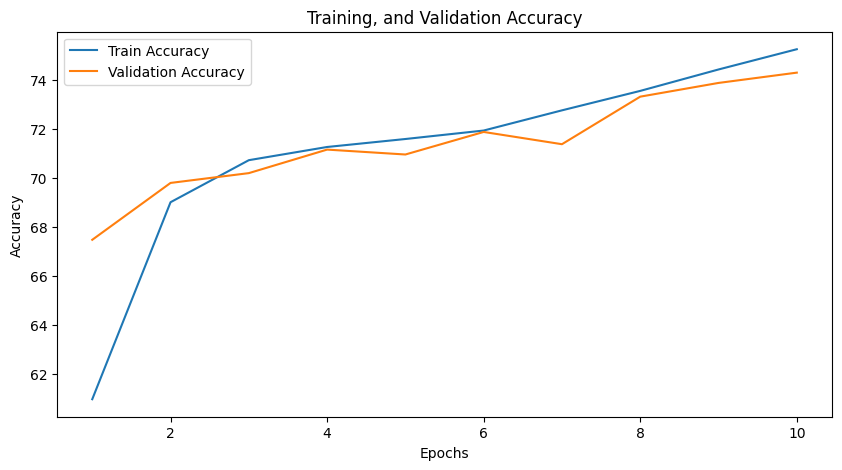

In [19]:
# Plot training and validation accuracy
train_accs = [i * 100 for i in train_accs]
val_accs = [i * 100 for i in val_accs]
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_accs, label="Train Accuracy")
plt.plot(range(1, EPOCHS + 1), val_accs, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training, and Validation Accuracy")
plt.legend()
plt.show()

### Plot training vs validation losses

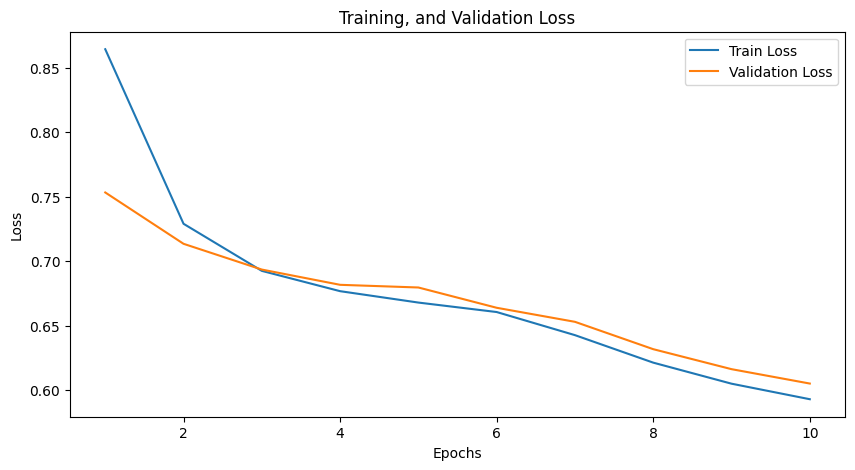

In [20]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training, and Validation Loss")
plt.legend()
plt.show()

### Plot Test Accuracy vs Epoch

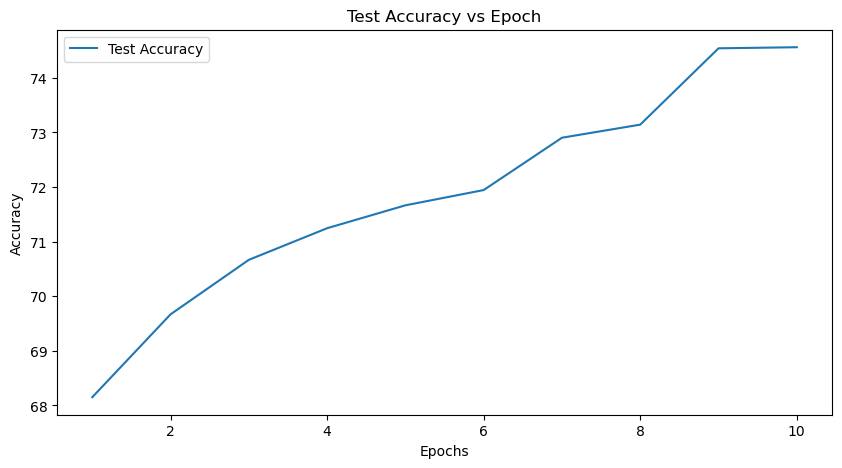

In [22]:
# Plot test accuracy vs epoch
# test_accs = [i * 100 for i in test_accs]
EPOCHS = 10
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), test_accs, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Test Accuracy vs Epoch")
plt.legend()
plt.show()

### Plot Test Loss vs Epoch

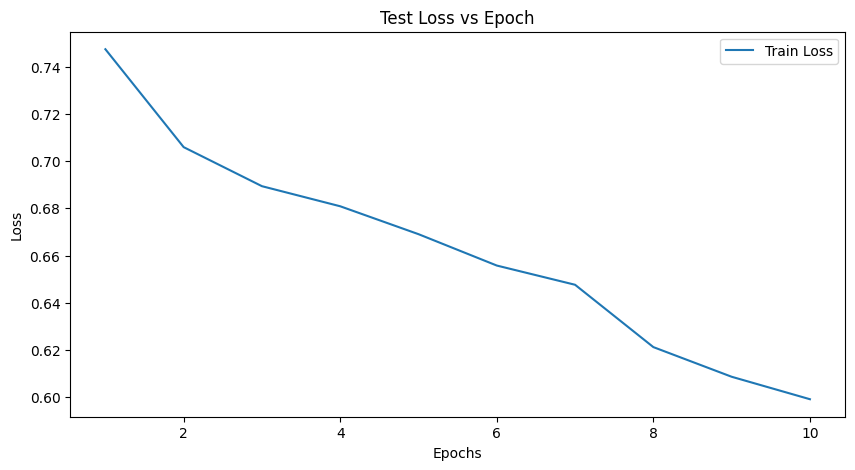

In [23]:
# Plot test loss vs epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), test_losses, label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Test Loss vs Epoch")
plt.legend()
plt.show()

### Save results in a dataframe

In [24]:
data = {
    'Train Accuracy': train_accs,
    'Validation Accuracy': val_accs,
    'Test Accuracy': test_accs,
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses,
    'Epoch Time': epoch_times
}

df = pd.DataFrame(data)

df.to_csv("lstm_results.csv")